khai báo các thư viện cần thiết như numpy, matplotlib, pandas,....

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model,Sequential,load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

khai báo dữ liệu

In [ ]:
data = pd.read_csv("Data/csgo_round_snapshots.csv")
pd.set_option('display.max_columns', None)

In [ ]:
data

biểu đồ số trận thắng ở những bản đồ khác nhau

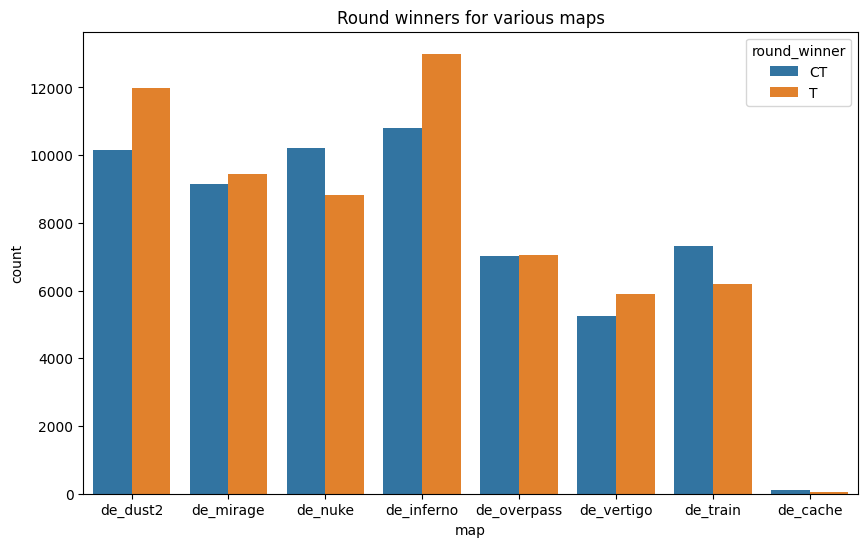

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="map", hue="round_winner", data=data)
ax.set(title='Round winners for various maps')
plt.show()

biểu đồ hiện thị tổng trận thắng của mỗi bên

tiền xử lí dữ liệu

In [ ]:
def preprocess_inputs(df):
    df = df.copy()

    # xóa bỏ các cột mà tất cả giá trị trong cột đó đều giống nhau

    for column in data.columns:
        if len(data[column].unique())==1:
            df = df.drop([column], axis=1)

    # mã hóa các cột về giá trị nhị phân

    df["bomb_planted"] = df["bomb_planted"].astype(np.int16)
    df["round_winner"] = df["round_winner"].replace({"T":0, "CT":1})

    # mã hóa các giá trị của cột map về các số nguyên

    map = ['de_dust2', 'de_mirage', 'de_nuke', 'de_inferno', 'de_overpass',
       'de_vertigo', 'de_train', 'de_cache']
    map_label = {}

    for i in range(len(map)):
      map_label[map[i]] = i
    df["map"] = df['map'].apply(lambda x : map_label[x])

    # chia dữ liệu, cụ thể y sẽ chứa kết quả round thắng hay thua, còn cột X sẽ chứa các đặc trưng

    y = df["round_winner"]
    X = df.drop("round_winner", axis=1)

    # Scaling the data

    scaler = RobustScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # chia dữ liệu thành 2 phần, tập huấn luyện và tập kiểm tra

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [ ]:
X_train.map

46932     0.000000
10028    -0.666667
54116     0.666667
97546     0.000000
2964      1.000000
            ...   
119879   -0.333333
103694    0.000000
860      -0.333333
15795    -0.666667
121958   -0.333333
Name: map, Length: 97928, dtype: float64

In [ ]:
X_train

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
46932,-0.548673,1.000000,1.285714,0.000000,1.0,-1.080000,-2.359551,0.023973,-0.846939,1.003759,-0.148936,0.50,-0.6,1.000000,-1.0,-3.0,0.0,-0.5,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,-0.333333,0.333333,-0.333333,1.0,0.0,0.0,-0.5,0.0,0.0
10028,-0.387777,1.285714,0.142857,-0.666667,0.0,-1.333333,-1.617978,-0.263699,0.027211,-0.390977,-0.346505,0.00,0.2,0.000000,-2.0,-1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.000000,-0.333333,0.000000,0.5,1.0,0.0,0.0,0.0,0.0
54116,-0.000089,1.571429,1.285714,0.666667,0.0,-0.793333,-0.028090,0.078767,0.554422,1.909774,0.848024,0.50,0.4,1.000000,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.000000,0.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.000000,1.000000,1.000000,0.666667,1.5,0.0,0.0,1.0,0.0,0.0
97546,0.042769,-0.285714,-0.142857,0.000000,0.0,0.000000,-1.269663,0.253425,0.112245,2.206767,-0.425532,0.50,0.2,1.000000,0.0,-1.0,1.0,1.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.000000,0.000000,1.333333,0.666667,1.5,0.0,0.0,0.5,0.0,0.0
2964,-0.000179,0.714286,0.857143,1.000000,0.0,0.000000,0.000000,0.373288,0.564626,1.421053,-0.422492,0.75,0.4,1.333333,0.0,0.0,0.0,1.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,-0.666667,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.000000,0.333333,1.000000,1.000000,1.5,0.0,0.0,-0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
X_train.shape

(97928, 90)

1. Neuron network

In [ ]:
new_model = Sequential()
new_model.add(Dense(128, activation='relu', input_shape=(90,)))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(2, activation='sigmoid'))

new_model.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               11648     
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 62,194
Trainable params: 62,194
Non-trainable params: 0
_________________________________________________________________


In [ ]:
enc = OneHotEncoder()
y_train_onehot = enc.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test_onehot = enc.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
tf.config.run_functions_eagerly(True)
hist = new_model.fit(X_train, y_train_onehot,batch_size = 32,epochs = 20 ,validation_data=(X_test, y_test_onehot))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3060/3061 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.7532

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3061/3061 [==============================] - 109s 35ms/step - loss: 0.4558 - accuracy: 0.7532 - val_loss: 0.4395 - val_accuracy: 0.7556
Epoch 2/20
3061/3061 [==============================] - 109s 35ms/step - loss: 0.4354 - accuracy: 0.7652 - val_loss: 0.4351 - val_accuracy: 0.7678
Epoch 3/20
3061/3061 [==============================] - 108s 35ms/step - loss: 0.4234 - accuracy: 0.7742 - val_loss: 0.4311 - val_accuracy: 0.7750
Epoch 4/20
3061/3061 [==============================] - 108s 35ms/step - loss: 0.4102 - accuracy: 0.7837 - val_loss: 0.4191 - val_accuracy: 0.7782
Epoch 5/20
3061/3061 [==============================] - 106s 35ms/step - loss: 0.3943 - accuracy: 0.7943 - val_loss: 0.4140 - val_accuracy: 0.7865
Epoch 6/20
3061/3061 [==============================] - 105s 34ms/step - loss: 0.3773 - accuracy: 0.8066 - val_loss: 0.4069 - val_accuracy: 0.7896
Epoch 7/20
3061/3061 [==============================] - 109s 36ms/step - loss: 0.3585 - accuracy: 0.8210 - val_loss: 0.4099 - val

In [ ]:
new_model.save('model_1.h5')

In [ ]:
score = new_model.evaluate(X_test, y_test_onehot, verbose=1)

 13/766 [..............................] - ETA: 6s - loss: 0.4782 - accuracy: 0.8221

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


766/766 [==============================] - 8s 10ms/step - loss: 0.4489 - accuracy: 0.8371


In [ ]:
score[1]

0.8371047973632812

In [ ]:
x = np.arange(0,20)

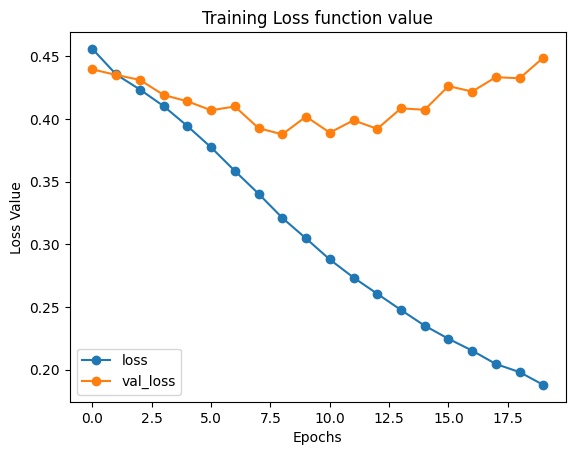

In [ ]:
plt.plot(x, hist.history['loss']  ,'-o',label = 'loss')
plt.plot(x ,hist.history['val_loss'],'-o',label = 'val_loss')
plt.legend()
plt.title('Training Loss function value')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.show()

Load model train sẵn

In [ ]:
model = load_model('/sourceCode/model.h5')

In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose=1)

 13/766 [..............................] - ETA: 6s - loss: 0.4782 - accuracy: 0.8221

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


766/766 [==============================] - 8s 10ms/step - loss: 0.4489 - accuracy: 0.8371


In [ ]:
accuracy0 = score[1]
accuracy0

0.8371047973632812

2. Navie Bayes

In [ ]:
NB = GaussianNB()
NB.fit(X_train, y_train)

y_predict2 = NB.predict(X_test)
accuracy1 = accuracy_score(y_test, y_predict2)
accuracy1

0.6178008332652561

              precision    recall  f1-score   support

           0       0.58      0.93      0.71     12478
           1       0.80      0.30      0.43     12004

    accuracy                           0.62     24482
   macro avg       0.69      0.61      0.57     24482
weighted avg       0.69      0.62      0.57     24482



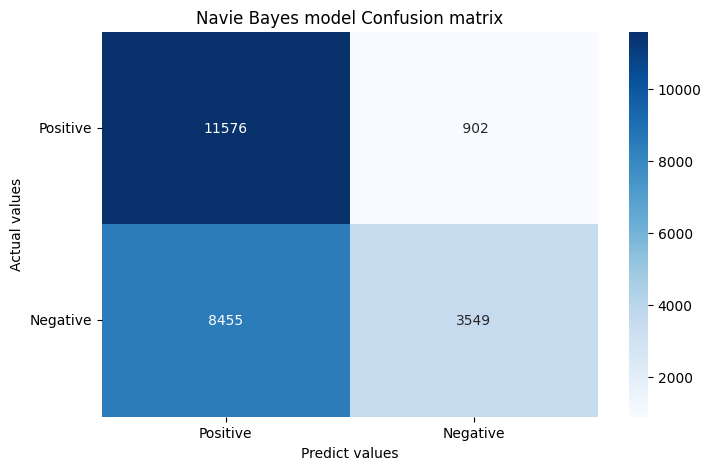

In [69]:
from sklearn.metrics import classification_report


print(classification_report(y_test,y_predict2))


conf_matrix = confusion_matrix(y_test, y_predict2)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix ,annot = True, fmt="4d",cmap="Blues", xticklabels= ['Positive',"Negative"], yticklabels= ['Positive',"Negative"])
plt.title('Navie Bayes model Confusion matrix')
plt.ylabel('Actual values')
plt.yticks(rotation = 0)
plt.xlabel('Predict values')
plt.show()

3. Logistic Regression

In [ ]:
LR = LogisticRegression(max_iter = 1000)
LR.fit(X_train, y_train)
y_predict3 = LR.predict(X_test)
accuracy2 = accuracy_score(y_test, y_predict3)
accuracy2


0.7491218037742015

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     12478
           1       0.74      0.76      0.75     12004

    accuracy                           0.75     24482
   macro avg       0.75      0.75      0.75     24482
weighted avg       0.75      0.75      0.75     24482



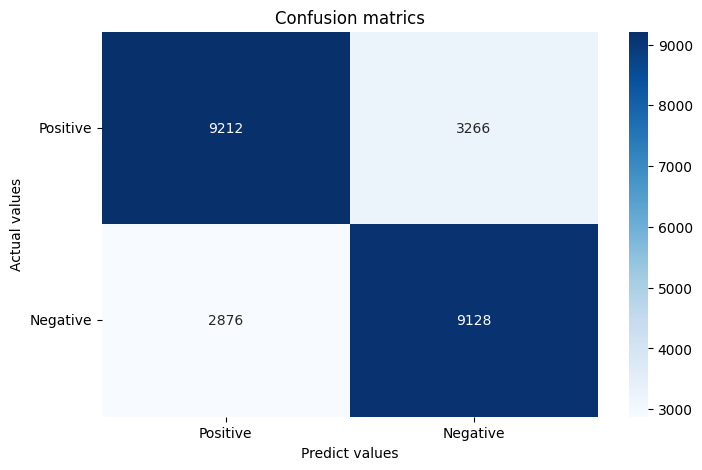

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_test,y_predict3))


conf_matrix = confusion_matrix(y_test, y_predict3)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix ,annot = True, fmt="4d",cmap="Blues", xticklabels= ['Positive',"Negative"], yticklabels= ['Positive',"Negative"])
plt.title('Confusion matrics')
plt.ylabel('Actual values')
plt.yticks(rotation = 0)
plt.xlabel('Predict values')
plt.show()

4. Decision Tree

In [ ]:
DTC = DecisionTreeClassifier(random_state=0)
DTC.fit(X_train, y_train)
y_predict4 = DTC.predict(X_test)
accuracy3 = accuracy_score(y_test, y_predict4)
accuracy3

0.817498570378237

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     12478
           1       0.81      0.81      0.81     12004

    accuracy                           0.82     24482
   macro avg       0.82      0.82      0.82     24482
weighted avg       0.82      0.82      0.82     24482



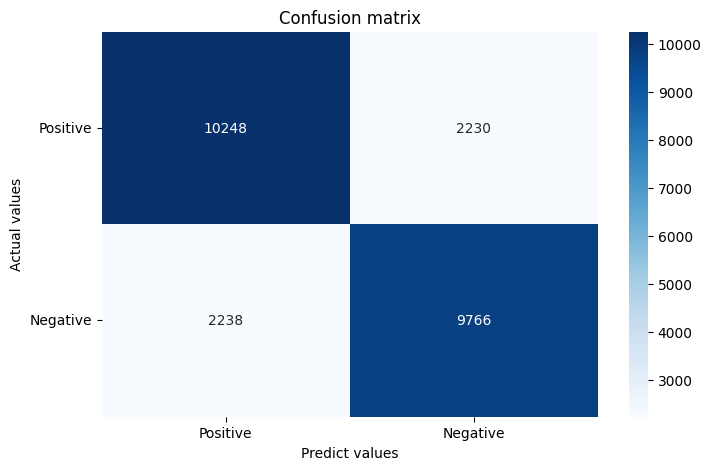

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_test,y_predict4))


conf_matrix = confusion_matrix(y_test, y_predict4)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix ,annot = True, fmt="4d",cmap="Blues", xticklabels= ['Positive',"Negative"], yticklabels= ['Positive',"Negative"])
plt.title('Confusion matrix')
plt.ylabel('Actual values')
plt.yticks(rotation = 0)
plt.xlabel('Predict values')
plt.show()

5. KNN

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train)
y_predict5 = KNN.predict(X_test)
accuracy4 = accuracy_score(y_test, y_predict5)
print(accuracy4)

0.8535658851401029


              precision    recall  f1-score   support

           0       0.86      0.85      0.86     12478
           1       0.85      0.86      0.85     12004

    accuracy                           0.85     24482
   macro avg       0.85      0.85      0.85     24482
weighted avg       0.85      0.85      0.85     24482



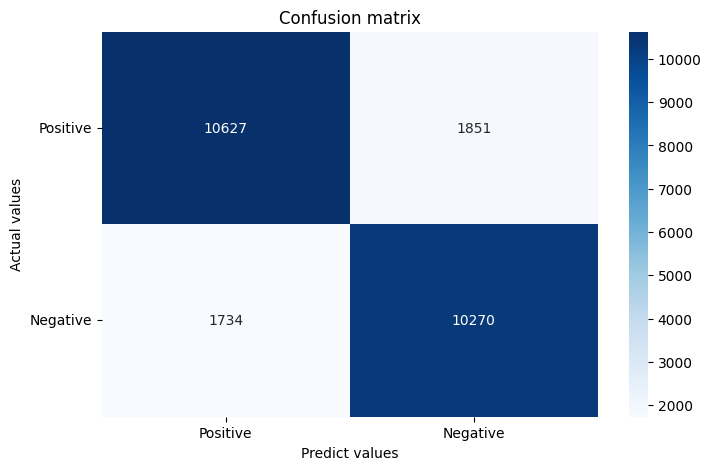

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_test,y_predict5))


conf_matrix = confusion_matrix(y_test, y_predict5)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix ,annot = True, fmt="4d",cmap="Blues", xticklabels= ['Positive',"Negative"], yticklabels= ['Positive',"Negative"])
plt.title('Confusion matrix')
plt.ylabel('Actual values')
plt.yticks(rotation = 0)
plt.xlabel('Predict values')
plt.show()

6. Random forest

In [ ]:
RF = RandomForestClassifier(random_state=0)
RF.fit(X_train, y_train)
y_predict6 = RF.predict(X_test)
accuracy5 = accuracy_score(y_test, y_predict6)
accuracy5

0.8792173842006372

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12478
           1       0.87      0.88      0.88     12004

    accuracy                           0.88     24482
   macro avg       0.88      0.88      0.88     24482
weighted avg       0.88      0.88      0.88     24482



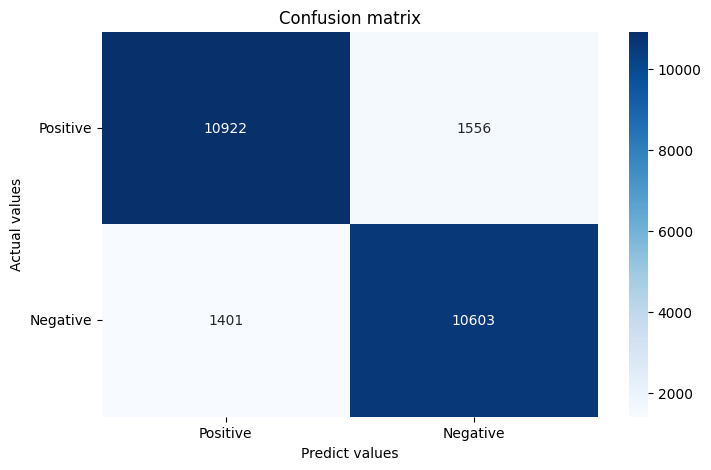

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_test,y_predict6))


conf_matrix = confusion_matrix(y_test, y_predict6)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix ,annot = True, fmt="4d",cmap="Blues", xticklabels= ['Positive',"Negative"], yticklabels= ['Positive',"Negative"])
plt.title('Confusion matrix')
plt.ylabel('Actual values')
plt.yticks(rotation = 0)
plt.xlabel('Predict values')
plt.show()

so sánh các mô hình

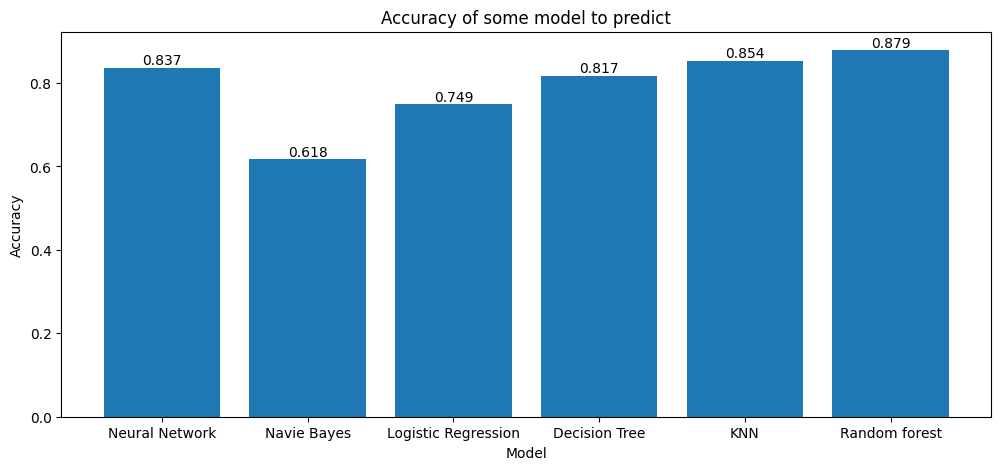

In [ ]:
x = ['Neural Network','Navie Bayes',
     'Logistic Regression','Decision Tree',
      'KNN', 'Random forest'
     ]
y = [accuracy0,accuracy1,accuracy2,accuracy3,accuracy4,accuracy5]


fig, ax = plt.subplots(figsize=(12, 5))
container = ax.bar(x,y)

ax.bar_label(container, fmt='{:.3f}')
ax.set_title('Accuracy of some model to predict')
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
plt.show()